In [1]:
#NOTE: Trained on the filtered CGM data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Glucose_processor import GlucoseDataProcessor
from models.model_B import BloodGlucosePredictorB

In [2]:
# Define prediction horizons (in minutes, adjust as needed)
horizons = [5, 10, 15, 30, 60]

# Initialize the BloodGlucosePredictor
bg_predictor = BloodGlucosePredictorB(horizons=horizons)

In [3]:
Glucose_data = GlucoseDataProcessor(CGM_file_path="CGM_data.csv", bolus_file_path="Bolus_data.csv", carb_file_path="Carb_data.csv",
                                    min_range=69, max_range=180, target=85, tp=75, td=280, dp=45, dd=180)


df = Glucose_data.create_filtered_DataFrame()

df

,Time,CGM,Insulin Activity,Food Activity
3255,2024-12-09 01:57:16,74.633941,0.000000,0.000000
3254,2024-12-09 02:02:16,77.013161,0.000000,0.000000
3253,2024-12-09 02:07:16,79.895722,0.000000,0.000000
3252,2024-12-09 02:12:16,83.361943,0.000000,0.000000
3251,2024-12-09 02:17:16,87.477852,0.000000,0.000000
...,...,...,...,...
4,2024-12-20 13:51:28,149.673834,0.032914,0.130190
3,2024-12-20 13:56:27,152.754635,0.032283,0.123480
2,2024-12-20 14:01:27,155.653519,0.031558,0.116350
1,2024-12-20 14:06:27,158.336854,0.030786,0.108902


In [4]:
# Preprocess the data
X_scaled, y_scaled = bg_predictor.preprocess_data(df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build the model
input_shape = (1, X_train.shape[1])  # Shape required for LSTM (timesteps=1, features=X_train.shape[1])
bg_predictor.build_model(input_shape=input_shape)

d:\DiaPulse\models\model_B.py:21: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)  # Linear interpolation for missing values
d:\DiaPulse\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
model_save_path = 'saved_models/model_B.keras'
history = bg_predictor.train(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=200,
    model_save_path=model_save_path
)

history

Epoch 1/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0994 - mae: 0.2671 - val_loss: 0.0355 - val_mae: 0.1369
Epoch 2/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - mae: 0.0835 - val_loss: 0.0320 - val_mae: 0.1358
Epoch 3/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - mae: 0.0778 - val_loss: 0.0307 - val_mae: 0.1345
Epoch 4/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - mae: 0.0691 - val_loss: 0.0290 - val_mae: 0.1291
Epoch 5/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - mae: 0.0702 - val_loss: 0.0262 - val_mae: 0.1235
Epoch 6/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - mae: 0.0669 - val_loss: 0.0244 - val_mae: 0.1209
Epoch 7/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mae: 0.0666 - val_loss: 0.0209 - val_mae: 0.1069
Epoch 8/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0624 - val_loss: 0.0158 - val_mae: 0.0992
Epoch 9/200
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

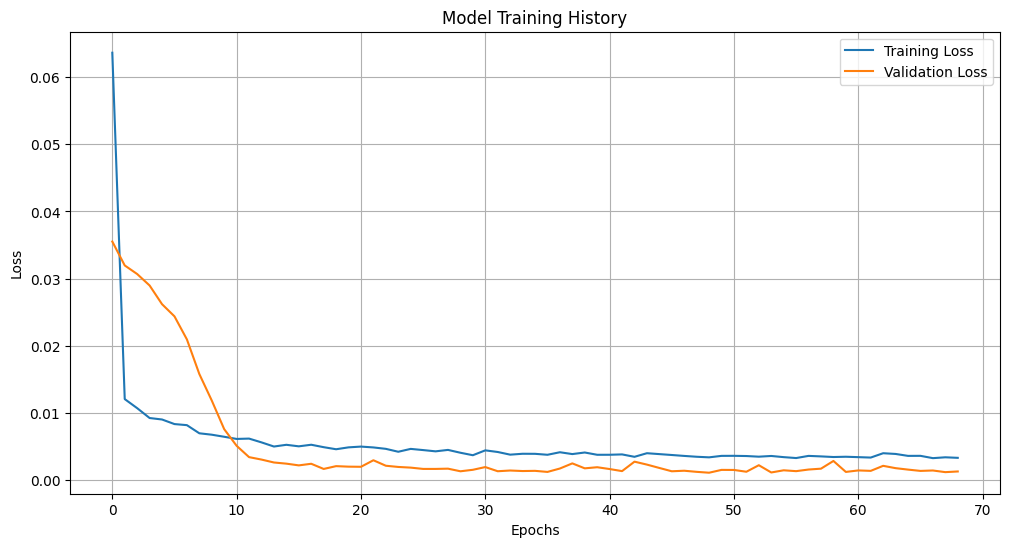

In [6]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Evaluate the model on test data
loss, mae = bg_predictor.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0010, Test MAE: 0.0187


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


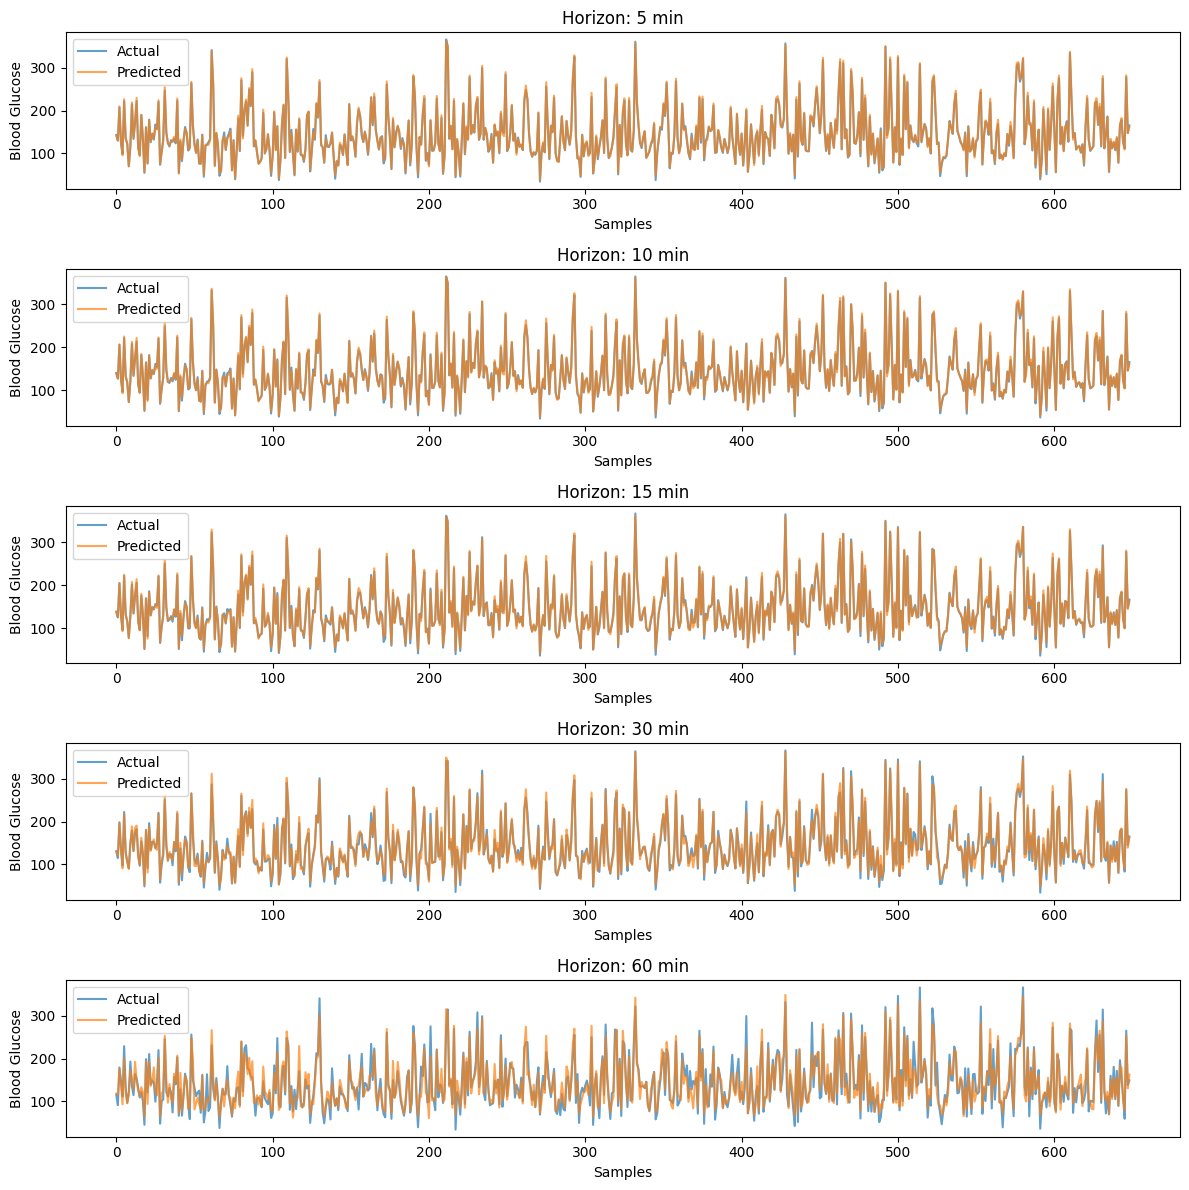

In [8]:
# Make predictions on test data
y_pred = bg_predictor.predict(X_test)

# Visualize predictions vs actual
plt.figure(figsize=(12, 12))
for i, horizon in enumerate(horizons):
    plt.subplot(len(horizons), 1, i + 1)
    plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], label='Actual', alpha=0.7)
    plt.plot(y_pred[:, i], label='Predicted', alpha=0.7)
    plt.title(f'Horizon: {horizon} min')
    plt.xlabel('Samples')
    plt.ylabel('Blood Glucose')
    plt.legend()
    plt.tight_layout()
plt.show()

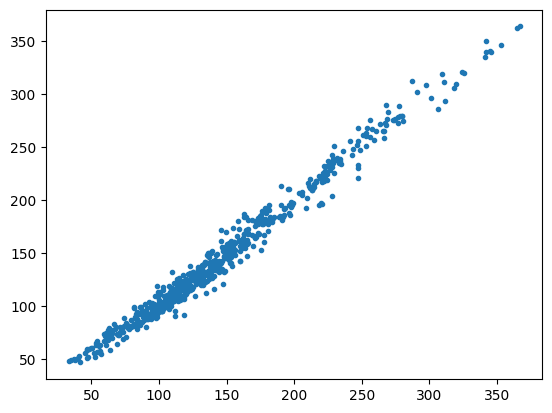

In [9]:
plt.figure()

i = 3 # Where {0: 5 min, 1: 10 min, 2: 15 min, 3: 30 min, 4: 60 min}

plt.plot(bg_predictor.scaler_y.inverse_transform(y_test)[:, i], y_pred[:, i], ".")